 <center> <h1> <b> Pattern Recognition and Machine Learning (EE5607) </b> </h1> </center>

<b> Programming Assignment - 03 : Statistical Classification</b>

<b> Instructions </b>
1. Plagiarism is strictly prohibited.
2. Delayed submissions will be penalized with a scaling factor of 0.5 per day.
3. Please DO NOT use any machine learning libraries unless and otherwise specified.



<b> Assignment on Linear Classification </b> <br>
In this programming assignment, you will get a chance to implement different linear classification models. You will start off with simple algorithms like Least Squares classification, LDA and FDA. Further you will be implementing perceptron algorithm. Finally you will be implementing probabilistic approaches for classification. To get further insights into these classification methods you will be drawing few critical comparisions between their performance and application scenario.




**Part-1) Least squares for classification**

1. Use Gaussian distribution with appropriate parameters and produce a dataset with 2 classes and 50 samples per class: the classes must live in the 2D space and be centered at (1,1) (2,2), both with variance 0.3. Further, generate a test set [X_test, Y_test] from the same distribution, starting with 200 samples per class.
2. Write a function LS_Classify to generate predictions Y_pred for the 2-class data generated.
3. Evaluate the classification performance (prediction error) by comparing the predicted labels Y_pred to the true labels Y_test.
4. Visualize the obtained results, write a function to generate & visualize the decision boundary between the classes, either by showing the boundary line or by using different colors for the two regions. Overlay the test points using scatter.

In [ ]:
#All imports
import numpy as np
import matplotlib.pyplot as plt
import random
import math

Least Squares Classification Accuracy is : 0.88 and Error is :  0.12


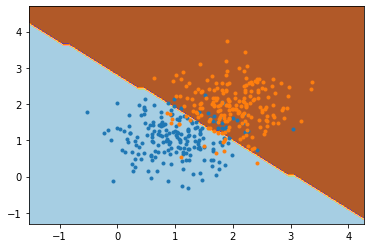

In [ ]:
########################################
#Part-2)-1: Data generation
########################################
def genDataset(mean,sigma,n):
    data={}
    a,b=mean.shape
    A=[np.random.multivariate_normal(mean[:,i],sigma*np.eye(a),size=(n)) for i in range(b)]
    X=np.array([])
    X=np.vstack(A[0])
    for i in range(1,len(A)):
        X=np.vstack((X,A[i]))
    Y=(np.array([[i]*n for i in range(b)])).flatten()

    data['data']=X
    data['target']=Y
    return data

mean=np.array([[1,1],[2,2]]).T

train_dataset=genDataset(mean,0.3,50)
test_dataset=genDataset(mean,0.3,200)

x_train=train_dataset['data']
y_train=train_dataset['target']
x_test=test_dataset['data']
y_test=test_dataset['target']

########################################
#Part-2)-2
########################################

def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def stack_onearray(x,N):
    one_array=np.ones((N,1))
    return np.hstack((one_array,x))

def getWeights(X_train, Y_train):
  N = X_train.shape[0]
  X = stack_onearray(X_train, N)
  num_class = len(np.unique(Y_train))
  T = one_hot(Y_train, num_class)
  W = (np.linalg.inv(X.T@X)@X.T)@T
  return W

def LS_Classify(X_train, Y_train, X_test):
  N = X_test.shape[0]
  X = stack_onearray(X_test, N)
  W = getWeights(X_train, Y_train)
  Y_pred = W.T @ X.T
  y_hat = np.array([])
  Y = Y_pred.T
  for i in range(Y_pred.shape[1]):
    result = np.unravel_index(Y[i].argmax(), Y[i].shape)
    y_hat = np.append(y_hat, result)
  return y_hat

##########################################
#Part-2)-3
##########################################
def LS_Classify_Accuracy(Y_test, Y_pred):
  correct = np.sum(Y_pred == Y_test)
  return correct/len(Y_test), (len(Y_test)-correct)/len(Y_test)

y_pred = LS_Classify(x_train, y_train, x_test)
acc, err = LS_Classify_Accuracy(y_test, y_pred)
print("Least Squares Classification Accuracy is :", acc, "and Error is : ", err)

##########################################
#Part-2)-4: Plot the classification results along with decision boundary
##########################################

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = LS_Classify(x_train, y_train, grid)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
for class_value in range(2):
    row_ix = np.where(y_test == class_value)
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')



<b> Part - (2) : Understanding Linear & Fisher Discriminant analysis </b>

Part - (2) (a) : In this part of the programming assignment, you will learn how to code linear discriminant projections and Fisher discriminant projections. 

1. Use Gaussian distribution with appropriate parameters and produce a dataset with 2 classes and 50 samples per class: the classes must live in the 2D space and be centered at (1,1) (2, 2), both with variance 0.3.
2. Write a function to perform projection from 2-D space to 1-D using Linear discriminant analysis. Please note that it considers only between-class covariance in to account
3. Project above generated 2-D synthetic data into 1-D and perform classification. Plot both original and projected data points in the same plot.
4. Write a function to perform projection from 2-D space to 1-D using Fisher discriminant analysis. Please note that it considers both between-class convariance and within-class covariance into account
5. Project above generated 2-D synthetic data into 1-D and perform classification. Plot both original and projected data points in the same plot.
6. Extend Fisher discriminant analysis function to project the data from N dimenision to K dimension. 

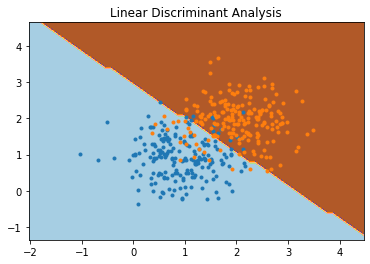

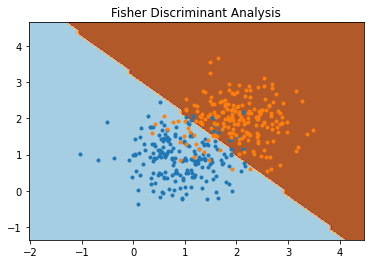

In [ ]:
#Part-(2) (a)

########################################
#Part-2)-(a) 1: Data generation
########################################
mean=np.array([[1,1],[2,2]]).T

train_dataset=genDataset(mean,0.3,50)
test_dataset=genDataset(mean,0.3,200)

x_train=train_dataset['data']
y_train=train_dataset['target']
x_test=test_dataset['data']
y_test=test_dataset['target']

########################################
#Part-2)-(a) 2: 
########################################

def getThreshold(X_train, Y_train, type):
  if type == "LDA":
    weights = getLDAweights(np.hstack([X_train, Y_train.reshape(len(Y_train),1)]))
    train_projections = LDA_project(X_train, weights)
  elif type == "FDA":
    weights = getFDAweights(np.hstack([X_train, Y_train.reshape(len(Y_train),1)]))
    train_projections = FDA_project(X_train, weights)

  x = np.hstack([train_projections.reshape(len(train_projections), 1), Y_train.reshape(len(Y_train),1)])
  n = np.unique(x[:,x.shape[1]-1])
  arr = np.array( [ list(x[x[:,x.shape[1]-1]==i,0]) for i in n] )
  means = []
  for i in range(arr.shape[0]):
    means.append(np.mean(arr[i]))
  threshold = np.mean(np.array(means))
  return threshold

def getLDAweights(x):
  n = np.unique(x[:,x.shape[1]-1])
  arr = np.array( [ list([x[x[:,x.shape[1]-1]==i,0], x[x[:,x.shape[1]-1]==i,1]]) for i in n] )
  means = []
  for i in range(arr.shape[0]):
    means.append(arr[i].mean(axis=1))
  means = np.array(means)
  
  #weights for two classes
  weights = means[1,:] - means[0,:]
  return weights

def LDA_project(x, weights):
  y_hat = weights@x.T
  return y_hat

########################################
#Part-2)-(a) 3
########################################
def LDA_classify(X_train, Y_train, X_test):
  weights = getLDAweights(np.hstack([X_train, Y_train.reshape(len(Y_train),1)]))
  threshold = getThreshold(X_train, Y_train, "LDA")
  test_projections = LDA_project(X_test, weights)
  Y_pred = np.array([])
  for i in range(len(test_projections)):
    if test_projections[i] <= threshold:
      Y_pred = np.append(Y_pred, 0)
    else:
      Y_pred = np.append(Y_pred, 1)
  return Y_pred

y_pred = LDA_classify(x_train, y_train, x_test)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = LDA_classify(x_train, y_train, grid)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
for class_value in range(2):
    row_ix = np.where(y_test == class_value)
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Linear Discriminant Analysis")
plt.show()

########################################
#Part-2)-(a) 4
########################################
def getFDAweights(x):
  n = np.unique(x[:,x.shape[1]-1])
  arr = np.array( [ list([x[x[:,x.shape[1]-1]==i,0], x[x[:,x.shape[1]-1]==i,1]]) for i in n] )
  means = []
  for i in range(arr.shape[0]):
    means.append(arr[i].mean(axis=1))
  means = np.array(means)
  
  #weights for two classes
  m2 = means[1,:].T.reshape(2,1)
  m1 = means[0,:].T.reshape(2,1)
  mean_diff = m2.T - m1.T

  mean = np.array([m1, m2])

  mean_diff = mean_diff.T

  S_w = 0

  for i in range(arr.shape[0]):
    for j in range(arr[i].shape[1]):
      x_n = arr[i].T[j].reshape(2,1)
      S_w += (x_n - mean[i])@(x_n - mean[i]).T

  weights = np.linalg.inv(S_w)@mean_diff

  return weights.reshape(weights.shape[0])

def FDA_project(x, weights):
  y_hat = weights@x.T
  return y_hat

########################################
#Part-2)-(a) 5
########################################
def FDA_classify(X_train, Y_train, X_test):
  weights = getFDAweights(np.hstack([X_train, Y_train.reshape(len(Y_train),1)]))
  threshold = getThreshold(X_train, Y_train, "FDA")
  test_projections = FDA_project(X_test, weights)
  Y_pred = np.array([])
  for i in range(len(test_projections)):
    if test_projections[i] <= threshold:
      Y_pred = np.append(Y_pred, 0)
    else:
      Y_pred = np.append(Y_pred, 1)
  return Y_pred

y_pred_fda = FDA_classify(x_train, y_train, x_test)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = FDA_classify(x_train, y_train, grid)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
for class_value in range(2):
    row_ix = np.where(y_test == class_value)
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Fisher Discriminant Analysis")
plt.show()


########################################
#Part-2)-(a) 6
########################################
def FDA_project_K(x, D):
  n = np.unique(x[:,x.shape[1]-1])
  arr = np.array( [ list([x[x[:,x.shape[1]-1]==i,0], x[x[:,x.shape[1]-1]==i,1]]) for i in n] )
  means = []
  for i in range(arr.shape[0]):
    means.append(arr[i].mean(axis=1))
  means = np.array(means)

  S_w = 0

  for i in range(arr.shape[0]):
    for j in range(arr[i].shape[1]):
      x_n = arr[i].T[j].reshape(2,1)
      S_w += (x_n - means[i])@(x_n - means[i]).T

  N = x.shape[1]-1

  mean_prime = np.mean(x[:, 0:N], axis=0).reshape(N,1)

  S_t = 0

  for i in range(x.shape[0]):
    xn = x[i,0:N].reshape(N,1)
    S_t += (xn - mean_prime)@(xn- mean_prime).T

  S_b = S_t - S_w

  matrix = np.linalg.inv(S_w)@S_b
  w, v = np.linalg.eig(matrix)

  idx = (-w).argsort()[:D]

  W = np.take(v, idx, axis=0)

  projection = W@x[:,0:N].T

  return projection.T
  
projections = FDA_project_K(np.hstack([x_train, y_train.reshape(len(y_train),1)]),1)

<b> Part (3) : Implimenting Perceptron Algorithm </b> 
1. Use Gaussian distribution with appropriate parameters and produce a dataset with 2 classes and 50 samples per class: the classes must live in the 2D space and be centered at (1,1) (2,2), both with variance 0.3. 
2. Implement perceptron algorithm and classify the above generated synthetic data using perceptron algorithm and plot the decision boundary/regions.
3. Add true outliers to one of the classes in the above generated synthetic data and perform classification using perceptron algorithm. Plot the decision boundary/regions. Compare and contrast the decision boundaries learned using least squares and perceptron approach.
4. Use Gaussian distribution with appropriate parameters and produce a dataset with four classes and 30 samples per class: the classes must live in the 2D space and be centered on the corners of the unit square (0,0), (0,1) (1,1), (1,0), all with variance 0.3. Obtain a 2-class train set [X, Y] by having data on opposite corners sharing the same class with labels +1 and -1. representing XOR problem and classify it using the perceptron algorithm.
5. Report your observations


Perceptron Classification Accuracy is : 0.8825 and Error is :  0.1175


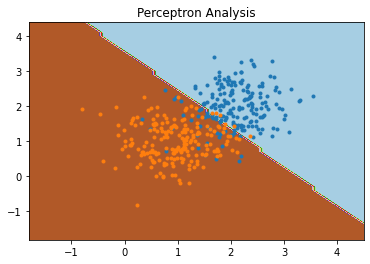

Least Squares Classification Accuracy (with outliers) is : 0.5121951219512195 and Error is :  0.4878048780487805
Perceptron Classification Accuracy (with outliers) is : 0.8853658536585366 and Error is :  0.11463414634146342


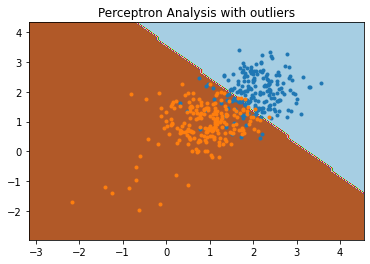

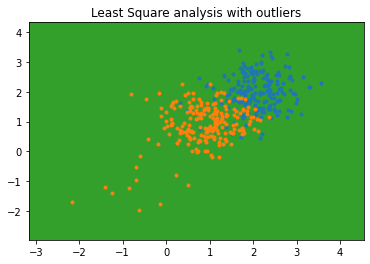

Perceptron Analysis accuracy with XOR Dataset : 0.5 and Error is :  0.5


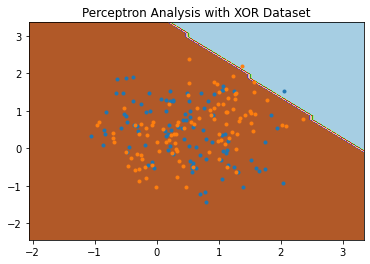

In [ ]:
########################################
#Part-3)-1: Data generation
########################################
def genDataset(mean,sigma,n):
    data={}
    a,b=mean.shape
    A=[np.random.multivariate_normal(mean[:,i],sigma*np.eye(a),size=(n)) for i in range(b)]
    X=np.array([])
    X=np.vstack(A[0])
    for i in range(1,len(A)):
        X=np.vstack((X,A[i]))
    Y=(np.array([[i]*n for i in range(b)])).flatten()

    data['data']=X
    data['target']=Y
    return data

mean=np.array([[1,1],[2,2]]).T

train_dataset=genDataset(mean,0.3,50)
test_dataset=genDataset(mean,0.3,200)

x_train=train_dataset['data']
y_train=train_dataset['target']
x_test=test_dataset['data']
y_test=test_dataset['target']

#coverting labels to +1 and -1

def convert(Y):
  for i in range(len(Y)):
    if Y[i] == 0 :
      Y[i] = 1
    else :
      Y[i] = -1
  
  return Y

y_train = convert(y_train)
y_test = convert(y_test)

########################################
#Part-3)-2
########################################

def getPercepWeights(X, Y):
  N = X.shape[0]
  X = stack_onearray(X, N)
  w = np.random.normal(0, 1, (3,))
  Y = Y.reshape(-1,1)

  eta = 0.01
  epochs = 100

  for t in range(epochs):
    out = X@w
    out[out<=0]=-1
    out[out>0]=1
    y_pred=np.array(out,dtype='int32')

    indices = [i for i, x in enumerate(y_pred) if x != y_train[i]]

    misclassified_points=X[indices]
    misclassified_labels = Y[indices]

    w=w+np.sum(0.01*misclassified_points*misclassified_labels,axis=0)

  return w

def Perceptron(X_train, Y_train, X_test, weights):
  N = X_test.shape[0]
  X_test = stack_onearray(X_test, N)
  
  out = X_test@weights
  y_pred = np.array([])
  for i in range(len(out)):
    if out[i]>=0:
      y_pred = np.append(y_pred, 1)
    else:
      y_pred = np.append(y_pred, -1)

  return y_pred

def percep_Classify_Accuracy(Y_test, Y_pred):
  correct = np.sum(Y_pred == Y_test)
  return correct/len(Y_test), (len(Y_test)-correct)/len(Y_test)

weights = getPercepWeights(x_train, y_train)
y_pred = Perceptron(x_train, y_train, x_test, weights)
acc, err = percep_Classify_Accuracy(y_test, y_pred)
print("Perceptron Classification Accuracy is :", acc, "and Error is : ", err)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = Perceptron(x_train, y_train, grid, weights)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Perceptron Analysis")
plt.show()

##########################################
#Part-3)-3: With outliers. Compare with Least Squares
##########################################
outlier_mean=np.array([[-1,-1]]).T

outliers = genDataset(outlier_mean,0.3,10)

x_test = np.append(x_test, outliers['data'], axis = 0)
y_test = np.append(y_test, convert(outliers['target']), axis = 0)

y_pred = LS_Classify(x_train, y_train, x_test)
acc, err = LS_Classify_Accuracy(y_test, y_pred)
print("Least Squares Classification Accuracy (with outliers) is :", acc, "and Error is : ", err)

y_pred = Perceptron(x_train, y_train, x_test, weights)
acc, err = percep_Classify_Accuracy(y_test, y_pred)

print("Perceptron Classification Accuracy (with outliers) is :", acc, "and Error is : ", err)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = Perceptron(x_train, y_train, grid, weights)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Perceptron Analysis with outliers")
plt.show()

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = LS_Classify(x_train, y_train, grid)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Least Square analysis with outliers")
plt.show()

##########################################
#Part-3)-4: Data generation XOR
##########################################

mean=np.array([[0,0],[0,1], [1,1],[1,0]]).T

train_dataset=genDataset(mean,0.3,30)
test_dataset=genDataset(mean,0.3,50)

x_train=train_dataset['data']
y_train=train_dataset['target']
x_test=test_dataset['data']
y_test=test_dataset['target']

y_train=2*(0.5-y_train%2)
y_test=2*(0.5-y_test%2)

y_pred = Perceptron(x_train, y_train, x_test, weights)
acc, err = percep_Classify_Accuracy(y_test, y_pred)

print("Perceptron Analysis accuracy with XOR Dataset :", acc, "and Error is : ", err)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
yhat = Perceptron(x_train, y_train, grid, weights)
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Perceptron Analysis with XOR Dataset")
plt.show()

# Part-3)-5:

Perceptron algorithm introduces many to one mapping for it uses a hard limiting function (sigmoid) at output. Weights are iteratively get updated by SGD with explicit use of misclassified examples. From above plots we can observe that, perceptron algorithm is only applicable on linearly applicable classes (failed for XOR Dataset). And also it does not offer any probablistic interpretations.

<b> Part-4) Logistic Regression </b>

1. Use Gaussian distribution with appropriate parameters and produce a dataset with 2 classes and 50 samples per class: the classes must live in the 2D space and be centered at (1,1) (2,2), both with variance 0.3. Further, generate a test set [X_test, Y_test] from the same distribution, starting with 200 samples per class.
2. Write a function Logistic_Regression to generate predictions Y_pred for the 2-class data generated.
3. Evaluate the classification performance (prediction error) by comparing the predicted labels Y_pred to the true labels Y_test.
4. Write a function to generate & visualize the decision boundary between the classes, either by showing the boundary line or by using different colors for the two regions. Overlay the test points using scatter.
5. Add true outliers to one of the classes to the data generated in the above generated data and perform the Least Squares classification and Logistic Regression for this data, plot the decision boundary/regions and write your observations on the difference between them.

Logistic Regression Classification Accuracy : 0.885 and Error is :  0.115


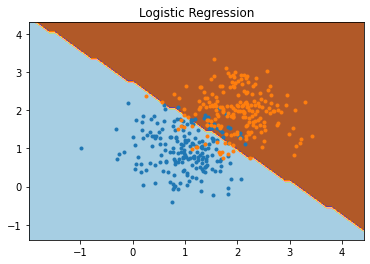

In [ ]:
##################################################
#Part-4)-1: Data generation
##################################################
mean=np.array([[1,1],[2,2]]).T

train_dataset=genDataset(mean,0.3,50)
test_dataset=genDataset(mean,0.3,200)

x_train=train_dataset['data']
y_train=train_dataset['target']
x_test=test_dataset['data']
y_test=test_dataset['target']

##################################################
#Part-4)-2:
##################################################

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigmoid_v = np.vectorize(sigmoid)

def Logistic_Regression(X_train, Y_train, X_test):
  max_iter = 100 #max number of iterations for parameter update
  threshold = 0.5 #threshold for classification
  N = X_train.shape[0]
  X_train = stack_onearray(X_train, N)
  weights = np.random.normal(0, 1, (X_train.shape[1],))
  
  for i in range(max_iter):
    yn = sigmoid_v(X_train@weights)
    yn_dash = np.ones(yn.shape) - yn
    R = np.diag(np.multiply(yn ,yn_dash))
    eta = np.linalg.inv(X_train.T@R@X_train)
    Z = (X_train@weights) - (np.linalg.inv(R)@(yn - Y_train))
    weights = eta @ X_train.T @ R @ Z

  N = X_test.shape[0]
  X_test = stack_onearray(X_test, N)

  y_pred = sigmoid_v(X_test@weights)

  y_pred[ y_pred <= threshold] = 0
  y_pred[ y_pred > threshold] = 1

  return weights, y_pred

_,  y_pred = Logistic_Regression(x_train, y_train, x_test)

###############################################
#Part-4)-3:
###############################################

def LR_Accuracy(Y_test, Y_pred):
  correct = np.sum(Y_pred == Y_test)
  return correct/len(Y_test), (len(Y_test)-correct)/len(Y_test)

acc, err = LR_Accuracy(y_test, y_pred)

print("Logistic Regression Classification Accuracy :", acc, "and Error is : ", err)

##########################################
#Part-4)-4: Plot the classification results along with decision boundary
##########################################

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
_, yhat = Logistic_Regression(x_train, y_train, grid) 
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Logistic Regression")
plt.show()

Logistic Regression Classification Accuracy (with outliers) is : 0.875609756097561 and Error is :  0.12439024390243902


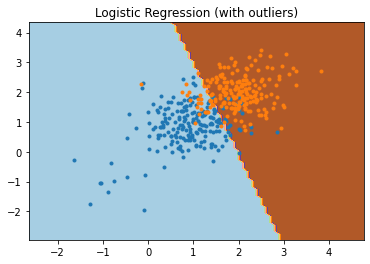

In [ ]:
##########################################
#Part-4)-5: Logistic regression for the data with true outliers
##########################################
mean=np.array([[1,1],[2,2]]).T

train_dataset=genDataset(mean,0.3,50)
test_dataset=genDataset(mean,0.3,200)

x_train=train_dataset['data']
y_train=train_dataset['target']
x_test=test_dataset['data']
y_test=test_dataset['target']

outlier_mean=np.array([[-1,-1]]).T

outliers = genDataset(outlier_mean,0.3,10)

x_test = np.append(x_test, outliers['data'], axis = 0)
y_test = np.append(y_test, outliers['target'], axis = 0)

_, y_pred = Logistic_Regression(x_train, y_train, x_test)
acc, err = LR_Accuracy(y_test, y_pred)
print("Logistic Regression Classification Accuracy (with outliers) is :", acc, "and Error is : ", err)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))
_, yhat = Logistic_Regression(x_train, y_train, grid) 
zz = yhat.reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("Logistic Regression (with outliers)")
plt.show()

# Observations

We can observe that presence of outliers doesnt affect the position and orientation of decision boundary. This is because "R" gets iteratively changed which plays the role of weighing i.e. how much weight it has to give to each example. So we get weighted L.S. with variable weights.

Also unlike perceptron, implicitly we are getting weight updates depending on classifications and misclassifications in logistic regression.

<b> Part (5) : Understanding decision boundaries of MAP approach to classification </b> 

Decision boundary in 2 class classification problem is the locus of points satisfying 

<center> $p(c_{1}/x)$ = $p(c_{2}/x)$ </center>

Where $c_{1}$ and $c_{2}$ are the class indicators  and x is the data. With proper assumpuptions on prior and likelihood, p(c/x) follows Gaussian distribution with appropriate parameters. Given the parameters of the Guassian distribution for the two classes i.e $\mu_{1},\Sigma_{1},\mu_{2},\Sigma_{2}$, we can derive the decision boundary equation i.e W and $w_{0}$. You may refer to class notes for the derivations and final equations. In this part of programming assignment we expect you to code the decision boundaries for the Gaussian distribution case and understand them. 

1. Use Gaussian distribution with appropriate parameters to generate a 2 class synthetic data.

Let us fix the class centers at (1,1) and (3,1). You can chose appropriate variance parameter to get better sepearable data. You are free to change class centers and variance of classes for better visualization.

>  Generate 100 samples from each class amounting to a total of 200 samples. This data set is used to understand the decision boundaries when $p(c_{1}) = p(c_{2})$

>  Generate 50 samples from class1 and 150 samples from class2. This data set is used to understand the decision boundaries when $p(c_{1}) < p(c_{2})$

>  Generate 150 samples from class1 and 50 samples from class2. This data set is used to understand the decision boundaries when $p(c_{1}) > p(c_{2})$

2. Please plots the decision boundaries for all the three cases in three different subplots.

3. Report your observations

**Optional** 
1. Plot the decision boundaries when the covariance matrix of $p(x/c_{1})$ i.e $\Sigma_{1}$ and $p(x/c_{2})$ i.e $\Sigma_{2}$ are different.



MAP Estimation Accuracy (N1=N2): 0.9975 and Error is :  0.0025


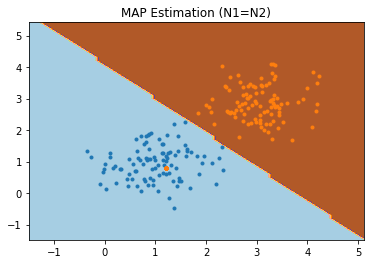

MAP Estimation Accuracy (N1<N2): 0.995 and Error is :  0.005


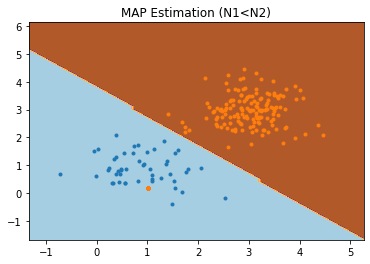

MAP Estimation Accuracy (N1>N2): 0.99 and Error is :  0.01


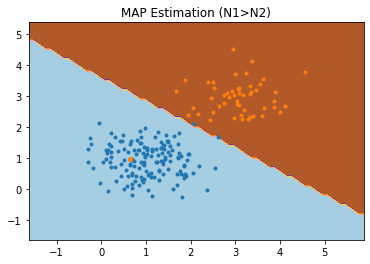

In [ ]:
##########################################
#Part-5)-1: Data Generation
##########################################

mean1 = [1,1]
mean2 = [3,3]


cov1 = [[0.3,0],[0,0.3]]
cov2 = [[0.3,0],[0,0.3]]


N1 = 100
N2 = 100

x1 = np.random.multivariate_normal(mean1, cov1, N1)
x2 = np.random.multivariate_normal(mean2, cov2, N2)

y1=np.zeros((N1,1))
y2=np.ones((N2,1))

x_train=np.vstack([x1,x2])
y_train=np.vstack([y1,y2])
training_list=[np.vstack([x1]),np.vstack([x2])]

N_test = 200

l1 = np.random.multivariate_normal(mean1, cov1, N_test)
l2 = np.random.multivariate_normal(mean2, cov2, N_test)

g1=np.zeros((N_test,1))
g2=np.ones((N_test,1))

x_test=np.vstack([l1,l2])
y_test=np.vstack([g1,g2])

##########################################
#Part-5)-2: Classification and decision boundary plots
##########################################

# 5.2.1
N1 = 100
N2 = 100

def getSharedCovMatrix(x, N1, N2):

  N = N1 + N2

  n = np.unique(x[:,x.shape[1]-1])
  
  class1 = x[x[:,x.shape[1]-1] == 0][:,0:x.shape[1]-1].T
  class2 = x[x[:,x.shape[1]-1] == 1][:,0:x.shape[1]-1].T

  means = []

  means.append(class1.mean(axis=1))
  means.append(class2.mean(axis=1))
    
  # arr = np.array( [ list([x[x[:,x.shape[1]-1]==i,0], x[x[:,x.shape[1]-1]==i,1]]) for i in n] )

  means = np.array(means)
  
  m2 = means[1,:].T.reshape(2,1)
  m1 = means[0,:].T.reshape(2,1)
  
  sigma1 = 0

  for i in range(N1):
    z = (class1.T[i]).reshape(1,2) - m1
    sigma1 += z.T@z

  sigma1 = (1/N1)*sigma1

  sigma2 = 0

  for i in range(N2):
    z = (class2.T[i]).reshape(1,2) - m2
    sigma2 += z.T@z

  sigma2 = (1/N2)*sigma2

  sigma = (N1/N)*sigma1 + (N2/N)*sigma2

  return np.array([sigma]), m1, m2

def getPredictions(x_train, y_train, N1, N2, x_test):
  sigma, m1, m2 = getSharedCovMatrix(np.hstack([x_train, y_train.reshape(len(y_train),1)]), N1, N2)
  sigma_inv = np.linalg.inv(sigma)
  w = sigma_inv@(m1 - m2)
  w0 = -0.5*(m1.T@sigma_inv@m1) + 0.5*(m2.T@sigma_inv@m2) + np.log10(N1/N2)
  yhat = x_test@w + w0 * np.ones((x_test.shape[0],1))
  post_density_C1 = sigmoid_v(yhat)
  post_density_C1 = post_density_C1.reshape(-1,)
  ypred = np.array([])

  for i in range(post_density_C1.shape[0]):
    if post_density_C1[i] >= 0.5:
      ypred = np.append(ypred, 0)
    else:
      ypred = np.append(ypred, 1)

  return ypred

y_pred = getPredictions(x_train, y_train, N1, N2, x_test)

def MAP_Accuracy(Y_test, Y_pred):
  Y_test = Y_test.reshape(-1,)
  correct = np.sum(Y_pred == Y_test)
  return correct/len(Y_test), (len(Y_test)-correct)/len(Y_test)

acc, err = MAP_Accuracy(y_test, y_pred)

print("MAP Estimation Accuracy (N1=N2):", acc, "and Error is : ", err)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))

yhat = getPredictions(x_train, y_train, N1, N2, grid)
zz = yhat.reshape(xx.shape)

x_test = x_train
y_test = y_train

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("MAP Estimation (N1=N2)")
plt.show()


# 5.2.2

mean1 = [1,1]
mean2 = [3,3]

cov1 = [[0.3,0],[0,0.3]]
cov2 = [[0.3,0],[0,0.3]]

N1 = 50
N2 = 150

x1 = np.random.multivariate_normal(mean1, cov1, N1)
x2 = np.random.multivariate_normal(mean2, cov2, N2)

y1=np.zeros((N1,1))
y2=np.ones((N2,1))

x_train=np.vstack([x1,x2])
y_train=np.vstack([y1,y2])
training_list=[np.vstack([x1]),np.vstack([x2])]

N_test = 200

l1 = np.random.multivariate_normal(mean1, cov1, N_test)
l2 = np.random.multivariate_normal(mean2, cov2, N_test)

g1=np.zeros((N_test,1))
g2=np.ones((N_test,1))

x_test=np.vstack([l1,l2])
y_test=np.vstack([g1,g2])

y_pred = getPredictions(x_train, y_train, N1, N2, x_test)

def MAP_Accuracy(Y_test, Y_pred):
  Y_test = Y_test.reshape(-1,)
  correct = np.sum(Y_pred == Y_test)
  return correct/len(Y_test), (len(Y_test)-correct)/len(Y_test)

acc, err = MAP_Accuracy(y_test, y_pred)

print("MAP Estimation Accuracy (N1<N2):", acc, "and Error is : ", err)

#Plot

min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))

yhat = getPredictions(x_train, y_train, N1, N2, grid)
zz = yhat.reshape(xx.shape)

x_test = x_train
y_test = y_train

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("MAP Estimation (N1<N2)")
plt.show()

# 5.2.3

mean1 = [1,1]
mean2 = [3,3]

cov1 = [[0.3,0],[0,0.3]]
cov2 = [[0.3,0],[0,0.3]]

N1 = 150
N2 = 50

x1 = np.random.multivariate_normal(mean1, cov1, N1)
x2 = np.random.multivariate_normal(mean2, cov2, N2)

y1=np.zeros((N1,1))
y2=np.ones((N2,1))

x_train=np.vstack([x1,x2])
y_train=np.vstack([y1,y2])
training_list=[np.vstack([x1]),np.vstack([x2])]

N_test = 200

l1 = np.random.multivariate_normal(mean1, cov1, N_test)
l2 = np.random.multivariate_normal(mean2, cov2, N_test)

g1=np.zeros((N_test,1))
g2=np.ones((N_test,1))

x_test=np.vstack([l1,l2])
y_test=np.vstack([g1,g2])

y_pred = getPredictions(x_train, y_train, N1, N2, x_test)

def MAP_Accuracy(Y_test, Y_pred):
  Y_test = Y_test.reshape(-1,)
  correct = np.sum(Y_pred == Y_test)
  return correct/len(Y_test), (len(Y_test)-correct)/len(Y_test)

acc, err = MAP_Accuracy(y_test, y_pred)

print("MAP Estimation Accuracy (N1>N2):", acc, "and Error is : ", err)

#Plot


min1, max1 = x_test[:, 0].min()-1, x_test[:, 0].max()+1
min2, max2 = x_test[:, 1].min()-1, x_test[:, 1].max()+1

x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

xx, yy = np.meshgrid(x1grid, x2grid)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

grid = np.hstack((r1,r2))

yhat = getPredictions(x_train, y_train, N1, N2, grid)
zz = yhat.reshape(xx.shape)

x_test = x_train
y_test = y_train

plt.contourf(xx, yy, zz, cmap='Paired')
class_values = np.unique(y_test)

for i in range(2):
    row_ix = np.where(y_test == class_values[i])
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], marker='.', cmap='Paired')
plt.title("MAP Estimation (N1>N2)")
plt.show()

# Part 5 : Q3) Observations

We can observe that on changing number of samples in each class, only the prior term [ log(N1/N2) ] gets affected and the boundary gets shifted ( w0 shifts) accordingly towards more probable class. Hence priors affects only the bias parameters, not the orientation.